In [1]:
!python --version

Python 3.6.9


In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
pd.__version__

'1.1.5'

In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Conv1D, Input, Flatten, Dense, LSTM, Dropout
from tensorflow.keras import Model

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
tf.__version__

'2.3.0'

Technical indicators: these indicators are widely-used for stock price data. 

In [7]:
## https://stackoverflow.com/questions/57006437/calculate-rsi-indicator-from-pandas-dataframe/57037866
def RSI(df, n=14):
  df = pd.DataFrame(df)
  def rma(x, n, y0):
      a = (n-1) / n
      ak = a**np.arange(len(x)-1, -1, -1)
      return np.append(y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1))

  df['change'] = df.iloc[:].diff()
  df['gain'] = df['change'].mask(df.change < 0, 0.0)
  df['loss'] = -df['change'].mask(df.change > 0, -0.0)
  df.loc[n:,'avg_gain'] = rma( df.loc[n+1:,'gain'].values, n, df.loc[:n, 'gain'].mean())
  df.loc[n:,'avg_loss'] = rma( df.loc[n+1:,'loss'].values, n, df.loc[:n, 'loss'].mean())
  df['rs'] = df.avg_gain / df.avg_loss
  df['rsi_14'] = 100 - (100 / (1 + df['rs']))
  return df['rsi_14']

def weighted_moving_average(df, n=30):
  df = pd.DataFrame(df)
  weights = np.arange(1, n+1)
  res = df.iloc[:].rolling(n).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
  return res

## similar to Moving Average Convergence Divergence (MACD)
def MACD(df, slow=60, fast=10):
  df = pd.DataFrame(df)
  exp1 = df.ewm(span=fast, adjust=False).mean()
  exp2 = df.ewm(span=slow, adjust=False).mean()
  macd = exp1-exp2
  return macd

In [8]:
def create_features(data, name):
    data = data[['datetime', 'level']]
    data['pct_change_1m'] = data['level'].pct_change(periods=1)
    
    data['short_ma'] = data['level'].rolling(window=10).mean()
    data['short_ma_pct_change_baseline'] = (data['short_ma']-data['level'])/data['level']
    data['short_ma_pct_change_10m'] = data['short_ma'].pct_change(periods=10)
    data['short_std'] = data['level'].rolling(window=10).std()
    data['short_std_pct_change_10m'] = data['short_std'].pct_change(periods=10)

    data['long_ma'] = data['level'].rolling(window=60).mean()
    data['long_ma_pct_change_baseline'] = (data['long_ma']-data['level'])/data['level']
    data['long_ma_pct_change_60m'] = data['long_ma'].pct_change(periods=60)
    data['long_std'] = data['level'].rolling(window=60).std()
    data['long_std_pct_change_60m'] = data['long_std'].pct_change(periods=60)

    data['short_ewm'] = data['level'].ewm(span=10, adjust=False).mean()
    data['short_ewm_pct_change_baseline'] = (data['short_ewm']-data['level'])/data['level']

    data['long_ewm'] = data['level'].ewm(span=60, adjust=False).mean()
    data['long_ewm_pct_change_baseline'] = (data['long_ewm']-data['level'])/data['level']

    ## technical indicators
    data['rsi'] = RSI(data['level'], n=30)
    data['wma'] = weighted_moving_average(data['level'], n=30)
    data['wma_pct_change'] = data['wma'].pct_change(periods=1)
    data['macd'] = MACD(data['level'], slow=60, fast=10)

    # data = data.drop(['level', 'short_ma', 'long_ma', 'short_std', 'long_std', 'short_ewm', 'long_ewm'], axis=1)
    # data = data.drop(['level', 'short_ma', 'long_ma', 'short_std', 'long_std'], axis=1)

    rename_mapper = {col: name+'_'+col for col in data.columns[1:]}
    data = data.rename(columns=rename_mapper)
    return data

In [9]:
def create_dataset(data, window_size=5, batch_size=32, shuffle=False):
    data = data.dropna()
    data = data.reset_index()
    data = data.drop(['index', 'datetime'], axis=1)
    # target = np.concatenate((np.zeros(window_size), data['sym_pct_change_1m'][window_size:]))
    target =  data['sym_pct_change_1m']
    x = np.array(data)
    
    ts_dataset = TimeseriesGenerator(x, target, 
                                     length=window_size, 
                                     stride=1,
                                     batch_size=batch_size, 
                                     shuffle=shuffle)
    
    return ts_dataset
    

In [10]:
def train_val_test_split(data, window_size=5, batch_size=32, train_pct=0.7, val_pct=0.2, shuffle=False):
    data = data.dropna()
    n = data.shape[0]
    n_train = int(n*train_pct)
    n_validation = int(n*val_pct)
    n_test = n-n_train-n_validation
    print("number of total data samples", n, "n_train", n_train, "n_validation", n_validation, "n_test", n_test)
    train_data = data.iloc[:n_train].copy()
    validation_data = data.iloc[n_train-window_size:n_train+n_validation].copy()
    test_data = data.iloc[n_train+n_validation-window_size:].copy()
    
    ## feature scaling
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    train_data.iloc[:, 1:] = scaler.fit_transform(train_data.iloc[:, 1:])
    validation_data.iloc[:, 1:] = scaler.transform(validation_data.iloc[:, 1:])
    test_data.iloc[:, 1:] = scaler.transform(test_data.iloc[:, 1:])

    ## here, we can temporily use (batch_size=1, shuffle=False) to verify that the dataset object is correct
    train_dataset = create_dataset(train_data, window_size=window_size, 
                                   batch_size=batch_size, shuffle=shuffle)
    print("train number of batches", len(train_dataset))
    validation_dataset = create_dataset(validation_data, window_size=window_size, 
                                        batch_size=batch_size, shuffle=shuffle)
    print("validation number of batches", len(validation_dataset))
    test_dataset = create_dataset(test_data, window_size=window_size, 
                                  batch_size=batch_size, shuffle=shuffle)
    print("test number of batches", len(test_dataset))
    
#     i = 0
#     for x, y in train_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1

#     for x, y in validation_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1
    
#     for x, y in test_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1
        
    return train_dataset, validation_dataset, test_dataset, test_data, scaler

Baseline model: use the value from last trade

In [11]:
class Baseline_last_trade(Model):
    def __init__(self, name=None):
        super().__init__()
        self.model_name = 'Baseline_last_trade'

    def call(self, inputs):
        return tf.zeros_like(inputs[:, -1:, 0])

Baseline model class: use moving average from previous trades

In [12]:
class Baseline_ma(Model):
    def __init__(self, ma_index=None):
        super().__init__()
        if ma_index is None:
            raise ValueError('Index of moving average is needed for this baseline model')
        self.ma_index = ma_index

    def call(self, inputs):
        result = inputs[:, -1:, self.ma_index]
        return result

Conv1D model

In [13]:
def get_conv1d_model(input_shape, conv_width=None, filter_size=None):
    if conv_width is None:
        raise ValueError("conv_width is needed as a list of integers")
    if filter_size is None:
        raise ValueError("filter_size is needed as a list of integers")
    if len(conv_width) != len(filter_size):
        raise ValueError("len(conv_width) != filter_size")
    
    input_ = Input(input_shape)
    x = input_
    for width, filters in zip(conv_width, filter_size):
        x = Conv1D(filters=filters, kernel_size=(width,), activation='relu')(x)
        x = Dropout(0.5)(x)

    x = Flatten()(x)
#     x = Dense(64)(x)
    # x = Dense(16)(x)
    output_ = Dense(1)(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(delta=0.01),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

LSTM model

In [14]:
def get_LSTM_model(input_shape, units_list=None):
    if units_list is None:
        raise ValueError("units is needed as a list of integers")
    
    input_ = Input(input_shape)
    x = input_
    for units in units_list:
        x = LSTM(units, return_sequences=True, activation='tanh')(x)
        x = Dropout(0.5)(x)
        
    x = LSTM(units_list[-1], activation='tanh')(x)
    x = Dense(units_list[-1])(x)
    output_ = Dense(1)(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.1),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Linear regression model: to avoid overfitting, the window_size is reduced

In [15]:
def get_lr_model(input_shape, lr_window_size=5, units_list=None):
    input_ = Input(input_shape)
    x = input_[:, -lr_window_size:, :]
    x = Flatten()(x)
    output_ = Dense(1, kernel_regularizer='l1', bias_regularizer='l1')(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Ensemble model #1: simple average

In [16]:
def get_myMajority_model(input_shape, models=None):
    if models is None:
        raise ValueError('models are needed for this ensemble model')
    for model in models:
      model.trainable = False
    input_ = Input(input_shape)
    outputs_ = [model(input_) for model in models]
    outputs_ = tf.stack(outputs_, axis=1)
    outputs_ = Flatten()(outputs_)
    outputs_ = tf.math.reduce_mean(outputs_, axis=1, keepdims=True)
    model = Model(inputs=input_, outputs=outputs_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Ensemble model #2: learned weighted average

In [17]:
def get_myEnsStack_model(input_shape, models=None):
    if models is None:
        raise ValueError('models are needed for this ensemble model')
    for model in models:
      model.trainable = False
    input_ = Input(input_shape)
    outputs_ = [model(input_) for model in models]
    outputs_ = tf.stack(outputs_, axis=1)
    outputs_ = Flatten()(outputs_)
    outputs_ = Dense(1, use_bias=False)(outputs_)
    model = Model(inputs=input_, outputs=outputs_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

The following function helps compute the actual root-mean-square error of our predicted level. Also, the predictions are made one by one to simulate the real-time prediction.

In [18]:
def model_eval(model, data, scaler):
    i = 0
    RMSE_raw = []
    RMSE_pct = []
    RMSE_level = []

    preds_raw = []
    preds_pct = []
    preds_level = []
    for i in range(len(data)-window_size):
      input_ = data.iloc[i:i+window_size, 1:]
      input_ = scaler.transform(input_)
      # print(input_[0])
      input_ = tf.expand_dims(input_, axis=0)

      last_row = data.iloc[i+window_size-1, 1:]
      last_price = last_row[0]

      target_row = np.array(data.iloc[i+window_size, 1:])
      target_row = np.expand_dims(target_row, axis=0)
      transformed_target_row = scaler.transform(target_row)
      transformed_target = transformed_target_row[:, 1]
      target_level = target_row[:, 0]
      target_pct = target_row[:, 1]
      
      transformed_pred_pct = model(input_).numpy()[0, 0]
      transformed_pred_row = np.zeros_like(target_row)
      transformed_pred_row[:, 1] = transformed_pred_pct
      pred_row = scaler.inverse_transform(transformed_pred_row)

      if hasattr(model, 'model_name') and model.model_name == 'Baseline_last_trade':
        pred_pct = np.array([0.0])
      else:
        pred_pct = pred_row[:, 1]

      pred_level = last_price * (1+pred_pct)
      preds_pct.append(pred_pct)
      preds_level.append(pred_level)

      RMSE_raw.append(tf.math.squared_difference(transformed_target.astype('float32'), transformed_pred_pct.astype('float32')))
      RMSE_pct.append(tf.math.squared_difference(target_pct.astype('float32'), pred_pct.astype('float32')))
      RMSE_level.append(tf.math.squared_difference(target_level.astype('float32'), pred_level.astype('float32')))

      rmse_raw = tf.math.sqrt(tf.math.reduce_mean(RMSE_raw)).numpy()
      rmse_pct = tf.math.sqrt(tf.math.reduce_mean(RMSE_pct)).numpy()
      rmse_level = tf.math.sqrt(tf.math.reduce_mean(RMSE_level)).numpy()
      # break
      
    return rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level

# Load data

In [19]:
file_path = "/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/bond_spreads.csv"
data = pd.read_csv(file_path, index_col=0)
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by='datetime')
data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,datetime,sym,level
0,2020-11-01 08:00:00,US0ATXMR1KXH,135.484079
1,2020-11-01 08:00:00,US1Q9L9LWF70,134.431820
2,2020-11-01 08:00:00,US6KJNEMVUB3,173.589274
3,2020-11-01 08:00:00,USVB60AAKLSG,168.731458
4,2020-11-01 08:00:00,US0GLYO7VCOH,81.383554


In [20]:
df_sym_to_sector = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/sym_to_sector.csv')
# df_sym_to_sector.head()
df_sym_to_sector['sector'].value_counts()

CONSUMER_CYCLICALS    512
INDUSTRIALS           330
ENERGY                311
TECHNOLOGY            292
Name: sector, dtype: int64

In [21]:
df_sym_to_issuer = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/sym_to_issuer.csv')
df_sym_to_issuer['issuer'].value_counts()

HGJU    94
ECH     94
XOY     93
X       87
TA      86
F       85
J       73
EEQ     60
ZBPY    55
T       53
FV      50
D       42
OERT    41
RY      40
NL      40
U       39
YVPO    39
MH      38
Q       36
LFU     31
XPHX    30
XG      29
LGK     29
XZET    26
EJMR    23
TOT     20
C       18
VYIV    15
NMYQ    13
RYDM    13
B       10
I        8
AH       8
SPW      7
XRC      5
WNR      4
KNRI     4
M        2
GV       2
TT       1
OFR      1
GK       1
Name: issuer, dtype: int64

In [22]:
raw_data = data.merge(df_sym_to_sector, on='sym')
raw_data = raw_data.merge(df_sym_to_issuer, on='sym')
raw_data.head()

,datetime,sym,level,sector,issuer
0,2020-11-01 08:00:00,US0ATXMR1KXH,135.484079,CONSUMER_CYCLICALS,XOY
1,2020-11-01 08:01:00,US0ATXMR1KXH,133.008120,CONSUMER_CYCLICALS,XOY
2,2020-11-01 08:02:00,US0ATXMR1KXH,133.269386,CONSUMER_CYCLICALS,XOY
3,2020-11-01 08:03:00,US0ATXMR1KXH,132.534590,CONSUMER_CYCLICALS,XOY
4,2020-11-01 08:04:00,US0ATXMR1KXH,134.908804,CONSUMER_CYCLICALS,XOY


In [23]:
syms_all = raw_data['sym'].unique()
syms_all

array(['US0ATXMR1KXH', 'US1Q9L9LWF70', 'US6KJNEMVUB3', ...,
       'USL3W14NOS6O', 'USOYXI6CIQ2M', 'USS7E04EJOAJ'], dtype=object)

Select a target sym

In [24]:
# sym = 'USV9CQ7RNR6Y'
sym = np.random.choice(syms_all, 1)[0]
sym_data = raw_data[raw_data['sym']==sym].reset_index().drop('index', axis=1)
sym_data.head()

,datetime,sym,level,sector,issuer
0,2020-11-01 08:00:00,US3ZG134NSVN,32.951116,TECHNOLOGY,EEQ
1,2020-11-01 08:01:00,US3ZG134NSVN,31.950413,TECHNOLOGY,EEQ
2,2020-11-01 08:02:00,US3ZG134NSVN,31.829991,TECHNOLOGY,EEQ
3,2020-11-01 08:03:00,US3ZG134NSVN,30.936350,TECHNOLOGY,EEQ
4,2020-11-01 08:04:00,US3ZG134NSVN,32.117917,TECHNOLOGY,EEQ


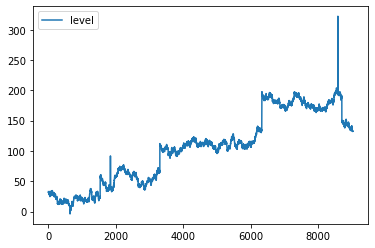

In [25]:
sym_data.plot(y='level')

Get sector and issuer data of this bond

1.   Compute the average price of the sector
2.   Compute the average price of the issuer

The intuition is: the bonds in the same sector or from the same issuer may provide some information for prediction of this bond. For example, the momentum of the aggregated price data can be informative to our model. 



In [26]:
sec = sym_data.loc[0, 'sector']
sec_data = raw_data[raw_data['sector']==sec]
sec_avg_price_data = sec_data.groupby(by='datetime').mean()
sec_avg_price_data = sec_avg_price_data.reset_index()
sec_avg_price_data.head()

,datetime,level
0,2020-11-01 08:00:00,110.578272
1,2020-11-01 08:01:00,108.467716
2,2020-11-01 08:02:00,111.496862
3,2020-11-01 08:03:00,105.816370
4,2020-11-01 08:04:00,109.714329


In [27]:
iss = sym_data.loc[0, 'issuer']
iss_data = raw_data[raw_data['issuer']==iss]
iss_avg_price_data = iss_data.groupby(by='datetime').mean()
iss_avg_price_data = iss_avg_price_data.reset_index()
iss_avg_price_data.head()

,datetime,level
0,2020-11-01 08:00:00,110.308273
1,2020-11-01 08:01:00,106.921838
2,2020-11-01 08:02:00,109.300647
3,2020-11-01 08:03:00,106.895427
4,2020-11-01 08:04:00,106.581457



#### Data usage: train_data: 70%, validation_data: 20%, test_data: 10%; in chronological order

In [28]:
train_pct=0.7
val_pct=0.2
# shuffle = False 
## here, we do not shuffle data during training, validation, testing; 
## it is easier to debug
## after debugging, it can be set to true
shuffle = True 

# Create features and targets, dataset (generotor)
Using sym, sector, issuer data

In [29]:
sym_feature_data = create_features(data=sym_data, name='sym')
sec_feature_data = create_features(data=sec_avg_price_data, name='sec')
issuer_feature_data = create_features(data=iss_avg_price_data, name='iss')

sym_feature_data.shape, sec_feature_data.shape, issuer_feature_data.shape

((9030, 21), (10000, 21), (10000, 21))

In [30]:
feature_data = sym_feature_data.merge(sec_feature_data, on='datetime')
feature_data = feature_data.merge(issuer_feature_data, on='datetime')
feature_data.dropna().head()

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
119,2020-11-01 10:09:00,32.451365,-0.040074,33.817558,0.042100,0.072846,0.653461,-0.208306,30.291944,-0.066543,0.006657,2.378575,0.035183,33.392082,0.028988,31.006398,-0.044527,53.664084,32.582674,0.002239,2.385684,111.374461,-0.016946,112.089718,0.006422,0.026880,1.096818,-0.572514,107.050413,-0.038824,0.000029,3.424558,0.580414,111.796505,0.003789,108.367091,-0.027002,53.078275,110.713422,0.001241,3.429414,110.116058,-0.026119,112.339096,0.020188,0.046763,2.205599,-0.202343,106.081554,-0.036639,-0.004494,3.832684,0.696307,111.469059,0.012287,107.554082,-0.023266,51.903928,109.991217,0.000998,3.914977
120,2020-11-01 10:10:00,32.688213,0.007299,33.730416,0.031883,0.060172,0.743569,-0.239050,30.287583,-0.073440,0.006512,2.373854,0.033141,33.264106,0.017618,31.061540,-0.049763,54.244593,32.661047,0.002405,2.202566,111.839724,0.004177,112.066654,0.002029,0.019174,1.099692,-0.443667,107.207617,-0.041417,0.002963,3.424307,0.587354,111.804363,-0.000316,108.480948,-0.030032,53.531933,110.861236,0.001335,3.323415,110.496228,0.003452,112.332823,0.016621,0.043449,2.211306,-0.249657,106.147291,-0.039358,-0.003489,3.874487,0.732962,111.292181,0.007203,107.650545,-0.025754,52.182017,110.110812,0.001087,3.641635
121,2020-11-01 10:11:00,32.186290,-0.015355,33.580148,0.043306,0.046128,0.890247,-0.170750,30.291642,-0.058865,0.006652,2.376939,0.034530,33.068139,0.027398,31.098417,-0.033799,52.794580,32.697095,0.001104,1.969722,110.834526,-0.008988,112.056996,0.011030,0.015261,1.111137,-0.324393,107.302745,-0.031865,0.004834,3.444742,0.651120,111.628029,0.007159,108.558114,-0.020539,52.399642,110.928207,0.000604,3.069915,108.086532,-0.021808,112.084087,0.036985,0.033234,2.545744,0.062896,106.216555,-0.017301,-0.001869,3.871335,0.752616,110.709335,0.024266,107.664840,-0.003901,50.275932,110.064189,-0.000423,3.044495
122,2020-11-01 10:12:00,31.212576,-0.030252,33.285217,0.066404,0.024889,1.131862,0.059504,30.279295,-0.029901,0.006173,2.370075,0.030808,32.730764,0.048640,31.102160,-0.003538,50.106589,32.659721,-0.001143,1.628604,110.021267,-0.007338,111.744121,0.015659,0.010227,1.205645,-0.353916,107.379194,-0.024014,0.006065,3.453461,0.661987,111.335891,0.011949,108.606086,-0.012863,51.488150,110.932587,0.000039,2.729804,110.583470,0.023101,111.816720,0.011152,0.026466,2.549254,-0.100818,106.294529,-0.038785,-0.001133,3.911857,0.770898,110.686451,0.000931,107.760533,-0.025528,52.149530,110.175324,0.001010,2.925918
123,2020-11-01 10:13:00,30.062931,-0.036833,32.825040,0.091878,0.002087,1.409985,0.134447,30.250129,0.006227,0.004716,2.361635,0.023480,32.245703,0.072607,31.068086,0.033435,47.173076,32.540062,-0.003664,1.177617,108.795597,-0.011140,111.383344,0.023785,0.006530,1.492195,-0.218367,107.405624,-0.012776,0.006733,3.458208,0.697322,110.874019,0.019104,108.612300,-0.0016

In [31]:
feature_data.shape

(9030, 61)

In [32]:
col_idx_map = {col: idx for idx, col in enumerate(feature_data.columns)}
# col_idx_map

#### Target variable: sym_pct_change_1m
We aim to predict the next-minute level, and the actual target variable is the percentage change of the next-minute level compared to current time (minute). 


sym_pct_change_1m (target) is stationary via test. 

In [33]:
result = adfuller(feature_data['sym_pct_change_1m'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -18.982494122712758
p-value: 0.0
Critical Values:
	1%: -3.431077443033014
	5%: -2.86186148257987
	10%: -2.5669411201499988


In [34]:
window_size = 20
batch_size = 32
feature_dim = feature_data.shape[1]-1

In [35]:
train_dataset, validation_dataset, test_dataset, test_data, scaler = train_val_test_split(feature_data, 
                                                                                          window_size=window_size, 
                                                                                          batch_size=batch_size,
                                                                                          train_pct=train_pct, 
                                                                                          val_pct=val_pct,
                                                                                          shuffle=shuffle)
## scaler: used to do feature scaling, and to transform data in model evaluation


number of total data samples 8911 n_train 6237 n_validation 1782 n_test 892
train number of batches 195
validation number of batches 56
test number of batches 28


### check the correctness of our created dataset object

In [36]:
transformed_feature_data = feature_data.dropna().copy()
transformed_feature_data.iloc[:, 1:] = scaler.transform(feature_data.dropna().iloc[:, 1:])
transformed_feature_data.head(1)

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
119,2020-11-01 10:09:00,-1.062501,-0.17089,-1.029031,0.060046,0.210546,-0.37308,-0.290571,-1.121374,-0.023269,-0.124034,-0.254031,-0.187322,-1.04039,0.06306,-1.103899,-0.018334,0.323771,-1.062244,0.185929,0.49182,0.70263,-0.719545,0.786861,0.297546,1.222137,-1.436205,-1.350657,0.301025,-1.059708,-0.053672,0.644564,1.178332,0.759623,0.193231,0.443436,-0.835649,0.981239,0.657351,0.632441,1.43812,0.218518,-0.695919,0.460333,0.686647,2.027768,-0.778471,-0.626315,-0.208319,-0.92938,-0.156362,0.258002,2.224417,0.369258,0.454959,-0.045325,-0.658769,0.874252,0.213958,0.441748,1.631368


In [37]:
if shuffle==False:
  for x, y in train_dataset:
      print("x.shape: (batch_size, window_size, feature_dimension)", x.shape)
      print("y.shape:", y.shape)
      init_idx = feature_data.dropna().index[0]
      transformed_row = np.array(scaler.transform(feature_data.iloc[init_idx:init_idx+window_size, 1:]))
      print("The first time step in the first sample:")
      print(x[0, 0, :])
      assert np.array_equal(x[0], transformed_row)
      target_row = np.array(feature_data.iloc[init_idx+window_size, 1:])
      target_row = scaler.transform(target_row[np.newaxis, :]) 
      assert np.array_equal(y[0], np.array(target_row[0, 1]))
      break

# Create, train and test models
The root_mean_squared_error presented here is computed based on the transformed target (percentage change of the next minute), which is not the RMSE of the predicted level of the next minute. The final evaluation of the models will be presented later. 



Baseline model #1: use the value from last trade

In [38]:
baseline_last_trade_model = Baseline_last_trade()
baseline_last_trade_model.compile(loss=tf.losses.MeanSquaredError(),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_last_trade_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0957


[0.009160738549586054, 0.0254733722844452, 0.09571174716662242]

Baseline model #2: use the short-term moving average from previous trades

In [39]:
baseline_st_ma = Baseline_ma(ma_index=col_idx_map['sym_short_ma_pct_change_baseline']-1) ## short-term moving average

baseline_st_ma.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_st_ma.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0745


[0.005545602055333022, 0.02883019649626698, 0.07446879781543217]

Baseline model #3: use the long-term moving average from previous trades

In [40]:
baseline_lt_ma = Baseline_ma(ma_index=col_idx_map['sym_long_ma_pct_change_baseline']-1) ## long-term moving average

baseline_lt_ma.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_lt_ma.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 2ms/step - loss: 0.0195 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.1395


[0.019465485443236372, 0.028518830687403105, 0.13951876357090037]

Conv1D model

In [41]:
conv1d_model = get_conv1d_model(input_shape=(window_size, feature_dim), 
                                conv_width=[10, 5, 2, 2], 
                                filter_size=[64, 64, 32, 16])
conv1d_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 60)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 64)            38464     
_________________________________________________________________
dropout (Dropout)            (None, 11, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 32)            

In [42]:
# # print('Input shape:', (window_size, 10))
# for x, y in train_dataset:
#     print('Input shape:', x.shape)
#     output_ = conv1d_model(x)
#     print('Output shape:', output_.shape)
#     print("Label shapre:", y.shape)
#     break


In [43]:
history = conv1d_model.fit(train_dataset, 
                            epochs=50, 
                            steps_per_epoch=len(train_dataset),
                            validation_data=validation_dataset, 
                            validation_steps=len(validation_dataset),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2)],
                            verbose=2)

Epoch 1/50
195/195 - 1s - loss: 0.0026 - mean_absolute_error: 0.2691 - root_mean_squared_error: 1.3289 - val_loss: 1.3825e-04 - val_mean_absolute_error: 0.0182 - val_root_mean_squared_error: 0.0232
Epoch 2/50
195/195 - 1s - loss: 9.8625e-04 - mean_absolute_error: 0.1034 - root_mean_squared_error: 0.9972 - val_loss: 1.3018e-04 - val_mean_absolute_error: 0.0174 - val_root_mean_squared_error: 0.0220
Epoch 3/50
195/195 - 1s - loss: 0.0010 - mean_absolute_error: 0.1058 - root_mean_squared_error: 1.1269 - val_loss: 1.3001e-04 - val_mean_absolute_error: 0.0174 - val_root_mean_squared_error: 0.0218
Epoch 4/50
195/195 - 1s - loss: 7.9806e-04 - mean_absolute_error: 0.0846 - root_mean_squared_error: 0.7151 - val_loss: 1.2741e-04 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0215
Epoch 5/50
195/195 - 1s - loss: 9.3427e-04 - mean_absolute_error: 0.0982 - root_mean_squared_error: 0.9103 - val_loss: 1.2881e-04 - val_mean_absolute_error: 0.0172 - val_root_mean_squared_error: 0.021

In [44]:
conv1d_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 3ms/step - loss: 2.2495e-04 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.1301


[0.00022494529418638974, 0.026948238085246056, 0.13006937819136832]

LSTM model

In [45]:
LSTM_model = get_LSTM_model(input_shape=(window_size, feature_dim),
                               units_list=[64, 64, 32, 16])
LSTM_model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 60)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            32000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 32)            12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 32)           

In [46]:
history = LSTM_model.fit(train_dataset, 
                          epochs=20, 
                          steps_per_epoch=len(train_dataset),
                          validation_data=validation_dataset, 
                          validation_steps=len(validation_dataset),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)],
                          verbose=2)

Epoch 1/20
195/195 - 5s - loss: 0.0667 - mean_absolute_error: 0.1483 - root_mean_squared_error: 1.4623 - val_loss: 2.4225e-04 - val_mean_absolute_error: 0.0175 - val_root_mean_squared_error: 0.0220
Epoch 2/20
195/195 - 3s - loss: 0.0302 - mean_absolute_error: 0.0976 - root_mean_squared_error: 0.8962 - val_loss: 7.8801e-04 - val_mean_absolute_error: 0.0349 - val_root_mean_squared_error: 0.0397
Epoch 3/20
195/195 - 3s - loss: 0.0696 - mean_absolute_error: 0.1407 - root_mean_squared_error: 1.6128 - val_loss: 0.0013 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0507
Epoch 4/20
195/195 - 3s - loss: 0.0338 - mean_absolute_error: 0.1012 - root_mean_squared_error: 0.8639 - val_loss: 5.3613e-04 - val_mean_absolute_error: 0.0272 - val_root_mean_squared_error: 0.0327


In [47]:
LSTM_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.1205


[0.0063571015478893446, 0.03719711623612878, 0.12045772098006485]

Linear regression model

In [48]:
my_lr_model = get_lr_model(input_shape=(window_size, feature_dim))
my_lr_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 60)]          0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 5, 60)]           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = my_lr_model.fit(train_dataset, 
                          epochs=20, 
                          steps_per_epoch=len(train_dataset),
                          validation_data=validation_dataset, 
                          validation_steps=len(validation_dataset),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)],
                          verbose=2)

Epoch 1/20
195/195 - 1s - loss: 0.1413 - mean_absolute_error: 0.2253 - root_mean_squared_error: 0.8156 - val_loss: 0.1027 - val_mean_absolute_error: 0.3404 - val_root_mean_squared_error: 0.3724
Epoch 2/20
195/195 - 1s - loss: 0.0809 - mean_absolute_error: 0.1927 - root_mean_squared_error: 0.8974 - val_loss: 0.0294 - val_mean_absolute_error: 0.1190 - val_root_mean_squared_error: 0.1473
Epoch 3/20
195/195 - 1s - loss: 0.0898 - mean_absolute_error: 0.2214 - root_mean_squared_error: 0.9790 - val_loss: 0.1570 - val_mean_absolute_error: 0.4709 - val_root_mean_squared_error: 0.5142
Epoch 4/20
195/195 - 1s - loss: 0.0764 - mean_absolute_error: 0.1944 - root_mean_squared_error: 0.6753 - val_loss: 0.0955 - val_mean_absolute_error: 0.2822 - val_root_mean_squared_error: 0.3541
Epoch 5/20
195/195 - 1s - loss: 0.0739 - mean_absolute_error: 0.1848 - root_mean_squared_error: 0.5480 - val_loss: 0.0439 - val_mean_absolute_error: 0.1391 - val_root_mean_squared_error: 0.1731


In [50]:
my_lr_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 3ms/step - loss: 0.0547 - mean_absolute_error: 0.1621 - root_mean_squared_error: 0.2508


[0.054661411723423585, 0.16205067341462892, 0.2507529324566122]

Majority-voting model (simple averaging) uses the above two models: conv1d and LSTM.







In [51]:
maj_model = get_myMajority_model(input_shape=(window_size, feature_dim), models=[conv1d_model, LSTM_model])
maj_model.summary() ## no trainable parameters

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 60)]     0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            64257       input_4[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            82977       input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_stack (TensorFlowOp [(None, 2, 1)]       0           functional_1[0][0]               
                                                                 functional_3[0][0]    

In [52]:
maj_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 11ms/step - loss: 0.0087 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.1608


[0.008746124727102662, 0.03268037196940679, 0.16077457042041987]

The ensemble model (weighted averaging) uses the above two models: conv1d and LSTM.


In [53]:
# ensStack_model = get_myEnsStack_model(input_shape=(window_size, feature_dim), models=[my_lr_model, conv1d_model, LSTM_model])
ensStack_model = get_myEnsStack_model(input_shape=(window_size, feature_dim), models=[conv1d_model, LSTM_model])
ensStack_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20, 60)]     0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            64257       input_5[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            82977       input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_stack_1 (TensorFlow [(None, 2, 1)]       0           functional_1[1][0]               
                                                                 functional_3[1][0]    

In [54]:
history = ensStack_model.fit(train_dataset, 
                            epochs=50, 
                            steps_per_epoch=len(train_dataset),
                            validation_data=validation_dataset, 
                            validation_steps=len(validation_dataset),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2)],
                            verbose=2)

Epoch 1/50
195/195 - 3s - loss: 0.0314 - mean_absolute_error: 0.1009 - root_mean_squared_error: 0.8163 - val_loss: 5.0027e-04 - val_mean_absolute_error: 0.0265 - val_root_mean_squared_error: 0.0316
Epoch 2/50
195/195 - 2s - loss: 0.0249 - mean_absolute_error: 0.0921 - root_mean_squared_error: 0.5253 - val_loss: 4.2060e-04 - val_mean_absolute_error: 0.0238 - val_root_mean_squared_error: 0.0290
Epoch 3/50
195/195 - 2s - loss: 0.0423 - mean_absolute_error: 0.1096 - root_mean_squared_error: 1.1238 - val_loss: 3.7139e-04 - val_mean_absolute_error: 0.0218 - val_root_mean_squared_error: 0.0273
Epoch 4/50
195/195 - 2s - loss: 0.0379 - mean_absolute_error: 0.1038 - root_mean_squared_error: 1.1220 - val_loss: 3.3072e-04 - val_mean_absolute_error: 0.0206 - val_root_mean_squared_error: 0.0257
Epoch 5/50
195/195 - 2s - loss: 0.0299 - mean_absolute_error: 0.0969 - root_mean_squared_error: 0.7346 - val_loss: 2.8797e-04 - val_mean_absolute_error: 0.0192 - val_root_mean_squared_error: 0.0240
Epoch 6/50

In [55]:
ensStack_model.evaluate(test_dataset, steps=len(test_dataset))

28/28 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.1532


[0.007804119259422545, 0.028460901762583816, 0.1531805664782975]

# Model evaluation
Here, we will compute the actual root-mean-square error of our predicted level. Also, the predictions are made one by one to simulate the real-time prediction (see the definition of model_eval). 

In [56]:
raw_test_data = feature_data.iloc[-len(test_data):,:].reset_index().drop('index', axis=1)
raw_test_data.head()

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
0,2020-11-17 13:50:00,166.390560,-0.007753,167.147476,0.004549,-0.012092,0.618931,0.128163,168.203156,0.010894,-0.024051,1.096633,-0.582743,167.329798,0.005645,168.726434,0.014039,42.795672,168.061090,-0.000853,-1.396636,79.823070,0.005053,79.479518,-0.004304,0.003745,2.184390,0.119473,80.828832,0.012600,-0.053376,2.212208,-0.343615,79.451587,-0.004654,80.900042,0.013492,49.226355,79.624154,-0.000181,-1.448455,87.870736,0.031273,86.953241,-0.010441,0.013200,5.213971,1.786454,88.154731,0.003232,-0.063070,4.131519,-0.159270,86.279169,-0.018113,88.359993,0.005568,49.805926,86.670960,0.000549,-2.080823
1,2020-11-17 13:51:00,166.144807,-0.001477,166.969522,0.004964,-0.012621,0.626528,-0.071809,168.148652,0.012061,-0.024503,1.116467,-0.569567,167.114345,0.005836,168.641791,0.015029,42.152190,167.908467,-0.000908,-1.527446,81.702499,0.023545,79.735968,-0.024069,0.004554,2.287924,0.251882,80.806887,-0.010962,-0.054053,2.196587,-0.340302,79.860844,-0.022541,80.926352,-0.009500,50.591039,79.734233,0.001382,-1.065509,85.787784,-0.023705,86.736830,0.011063,0.005188,5.212827,1.991772,88.056693,0.026448,-0.063578,4.116453,-0.163812,86.189827,0.004686,88.275658,0.029000,48.936724,86.583454,-0.001010,-2.085832
2,2020-11-17 13:52:00,165.918780,-0.001360,166.761478,0.005079,-0.012666,0.591024,-0.119194,168.110385,0.013209,-0.024727,1.152915,-0.555421,166.896970,0.005896,168.552512,0.015874,41.557664,167.747520,-0.000959,-1.655542,76.440522,-0.064404,79.081815,0.034554,-0.005668,2.189753,0.055728,80.727443,0.056082,-0.055057,2.266935,-0.317317,79.238967,0.036609,80.779276,0.056760,46.937139,79.496709,-0.002979,-1.540309,88.446484,0.030992,85.643702,-0.031689,-0.021729,2.901006,-0.355892,88.028527,-0.004726,-0.063593,4.107754,-0.168584,86.600128,-0.020875,88.281259,-0.001868,50.086909,86.670968,0.001011,-1.681131
3,2020-11-17 13:53:00,166.923355,0.006055,166.774551,-0.000891,-0.011417,0.593232,-0.374079,168.096094,0.007026,-0.024737,1.162345,-0.555426,166.901767,-0.000129,168.499097,0.009440,45.116732,167.658374,-0.000531,-1.597330,78.230451,0.023416,78.708947,0.006116,-0.015078,1.949663,-0.089116,80.680851,0.031323,-0.055688,2.289313,-0.308280,79.055601,0.010548,80.695708,0.031513,48.252316,79.386732,-0.001383,-1.640107,84.978533,-0.039210,85.412754,0.005110,-0.024674,2.846984,-0.367497,87.979089,0.035310,-0.065256,4.126585,-0.123978,86.305293,0.015613,88.172973,0.037591,48.609479,86.540177,-0.001509,-1.867680
4,2020-11-17 13:54:00,167.047742,0.000745,166.787307,-0.001559,-0.010051,0.598063,-0.448791,168.094452,0.006266,-0.024580,1.163778,-0.563041,166.928308,-0.000715,168.451511,0.008403,45.541539,167.581844,-0.000456,-1.523204,80.986047,0.035224,79.122588,-0.023010,-0.008893,1.950151,-0.132563,80.685522,-0.003711,-0.055921,2.289651,-0.298759,79.406591,-0.019503,80.705227,

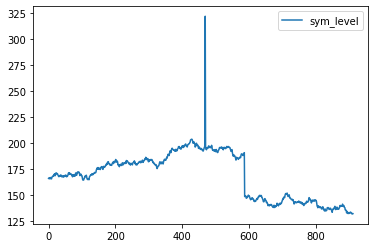

In [57]:
raw_test_data.plot(y='sym_level')

In [58]:
print("baseline_last_trade_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_baseline = model_eval(baseline_last_trade_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_baseline[:5]:
  print(pred)


baseline_last_trade_model
rmse_raw 0.11729313 rmse_pct 0.026750142 rmse_level 6.1840167
first 5 predicted levels:
[169.44445023]
[168.96286224]
[170.03500828]
[171.56779379]
[171.44305736]


In [59]:
print("conv1d_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_conv1d = model_eval(conv1d_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_conv1d[:5]:
  print(pred)


conv1d_model
rmse_raw 0.11720573 rmse_pct 0.026753519 rmse_level 6.182804
first 5 predicted levels:
[169.38064644172394]
[168.89923979652718]
[169.97098211628446]
[171.50319046576098]
[171.37850100062903]


In [60]:
print("LSTM_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_LSTM = model_eval(LSTM_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_LSTM[:5]:
  print(pred)


LSTM_model
rmse_raw 0.11980751 rmse_pct 0.027347406 rmse_level 6.284118
first 5 predicted levels:
[170.406263570164]
[169.92193875682676]
[171.00069493640714]
[172.54163994130548]
[172.41639502751002]


In [61]:
print("lr_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_lr = model_eval(my_lr_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_lr[:5]:
  print(pred)


lr_model
rmse_raw 0.21417256 rmse_pct 0.048887286 rmse_level 9.21896
first 5 predicted levels:
[177.96584863272687]
[169.63916111881994]
[173.3685784992711]
[167.8531937618186]
[167.4355149406139]


In [62]:
print("maj_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_maj = model_eval(maj_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
for pred in preds_level_maj[:5]:
  print(pred)


maj_model
rmse_raw 0.11775303 rmse_pct 0.02687845 rmse_level 6.211812
[169.893455005944]
[169.41058927667697]
[170.48583852634582]
[172.02241520353326]
[171.89744801406954]


In [63]:
print("ensStack_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_ens = model_eval(ensStack_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
for pred in preds_level_ens[:5]:
  print(pred)


ensStack_model
rmse_raw 0.11719041 rmse_pct 0.026750024 rmse_level 6.1839943
[169.44309492439677]
[168.9615105502597]
[170.03368738757837]
[171.56642001075258]
[171.4416995614984]


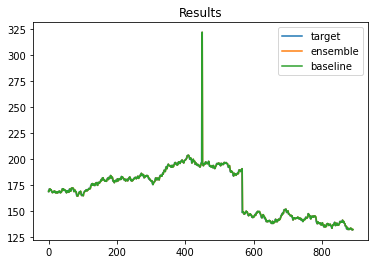

In [64]:
dates = raw_test_data.iloc[window_size:, 0]
target_level = raw_test_data.iloc[window_size:, 1]


plt.plot(range(len(target_level)), target_level, label='target')
plt.plot(range(len(preds_level_ens)), preds_level_ens, label='ensemble') 
plt.plot(range(len(preds_level_baseline)), preds_level_baseline, label='baseline')
plt.legend()
plt.title('Results')
plt.show()


Zoom-in plots

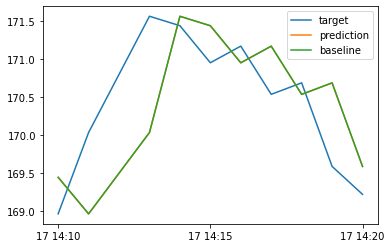

In [65]:
len_data = 10
zoomed_dates = raw_test_data.iloc[window_size:window_size+len_data, 0]
zoomed_target_level = raw_test_data.iloc[window_size:window_size+len_data, 1]
zoomed_preds_level_ens = preds_level_ens[:len_data]
zoomed_preds_level_baseline = preds_level_baseline[:len_data]

plt.plot(zoomed_dates, zoomed_target_level, label='target')
plt.plot(zoomed_dates, zoomed_preds_level_ens, label='prediction')
plt.plot(zoomed_dates, zoomed_preds_level_baseline, label='baseline')
plt.legend()

plt.show()

# Future work to improve the result: 

1.   Use cross-validation (time series) to determine hyperparameters, such as window_size, feature dimensions, number of layers, neurons in the neural networks.
2.   Add more learned models to the ensemble model, such as support vector regressor, xgboost, random forest, etc. 



# Online version of the model
In the current ensemble model, the weights of each model are also trained offline. 

Suppose we have $n$ trained (offline) models (experts). One approach to make it online:

We can formulate the online learning problem as a multi-armed bandit problem: at each time step, we pick an individual model (according to some learned distribution) and observe the cost (between prediction and the actual level); there are several well-known algorithms to achieve this, such as $\epsilon$-greedy, Upper Confidence Bounds (UCB), and Bayesian variants of UCBs. 

There are also online algorithms that can compute weighted average of $n$ experts, see the reference below. 

Reference: 
Cesa-Bianchi, Nicolo, and Gábor Lugosi. Prediction, Learning, and Games. Cambridge university press, 2006.



